# Transfer learning & fine-tuning
**This notebook is transfer learning and fine-tuning using mobilenet model and distracted-driver dataset with 10000 images** 

**Libraries:**


*   Tensorflow
*   Numpy
*   Matplotlib
*   Scikit-learn

**For original kaggle distracted drivers datasets (4.02 GB) go to this link:**

* https://www.kaggle.com/c/state-farm-distracted-driver-detection/data

**First download to your computer then use it**

**To work on colab first upload to your google drive**

**The driver_data link: https://drive.google.com/file/d/1UQkFCXONNyKlvjcleNrQa3XHRSDkHAVA/view?usp=sharing**

**On this Data only 10000 images in total**


**Mounting Google Drive**

**Importing files**

In [7]:
# !unzip "F:/1.SecondSemester/ComputerVision/MobileNet/Distracted_driver_data.zip"

**Declaring root data folder**

In [9]:
main_folder = 'F:/1.SecondSemester/ComputerVision/MobileNet/Distracted_driver/data' # This data folder is for training

**Importing Libraries**

In [55]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras import layers

from sklearn.metrics import confusion_matrix
from IPython.display import Image

import itertools
import os
import shutil
import random
import glob

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

**Declaring variables**

In [11]:
n_classes = 10
batch_size = 20                         
img_size = 224                         # img width & heaight
input_shape = (img_size, img_size, 3)  # input shape for model (width, height, channel)
seed = random.randint(1, 1000)         # Taking random seed 1~1000 for shuffling and transformations.
learning_rate = 0.001
epochs = 5

In [12]:
org_labels=['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']   # on kaggle our original data labeled as c0, c1 ... but we changed it to 0, 1 ... 
final_labels = ['Safe driving',
                'Texting using right hand',
                'Talking on the phone using right hand',
                'Texting using left hand',
                'Talking on the phone using left hand',
                'Operating (Adjusting) the radio',
                'Drinking',
                'Reaching behind',
                'Hair and makeup',
                'Talking to passenger']

**Spliting images into 3 datasets:**
* Total 10000 images
* Test dataset 2% of total images --> 200 images
* Train dataset 80% of remained 9800 images --> 7840 images
* Validation dataset 20% of remained 9800 --> images 1960 images


* Train and val datasets used for model training
* Test dataset is used for testing trained model

In [14]:
def orginize_data():
    # Organize data into train, valid, test dirs
    os.chdir(main_folder)
    if os.path.isdir('train/0/') is False: 
        os.mkdir('train')
        os.mkdir('valid')
        os.mkdir('test')

        for i in range(0, 10):
            shutil.move(f'{i}', 'train')
            os.mkdir(f'valid/{i}')
            os.mkdir(f'test/{i}')
    
            valid_samples = random.sample(os.listdir(f'train/{i}'), 196) #196 imgs in each validation/ folder
            for j in valid_samples:
                shutil.move(f'train/{i}/{j}', f'valid/{i}')

            test_samples = random.sample(os.listdir(f'train/{i}'), 20) #20 imgs in each test/ folder
            for k in test_samples:
                shutil.move(f'train/{i}/{k}', f'test/{i}')
    os.chdir('../..')

In [15]:
orginize_data()
train_path = (main_folder + '/train')
valid_path = (main_folder + '/valid')
test_path = (main_folder + '/test')

# Data preprocessing

In [16]:
# to visualize our preprocessed data 
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

**Default parameters of ImageDataGenerator(**
*    featurewise_center=False, samplewise_center=False,
*    featurewise_std_normalization=False,  samplewise_std_normalization=False,
*    zca_whitening=False, zca_epsilon=1e-06,
*    rotation_range=0, width_shift_range=0.0,
*    height_shift_range=0.0, brightness_range=None,
*    shear_range=0.0, zoom_range=0.0,
*    channel_shift_range=0.0, fill_mode="nearest",
*    cval=0.0, horizontal_flip=False,
*    vertical_flip=False, rescale=None,
*    preprocessing_function=None, data_format=None,
*    validation_split=0.0, dtype=None,)

**Default parameters of flow_from_directory(**
*    directory, labels="inferred", label_mode="int",
*    class_names=None, color_mode="rgb", batch_size=32,
*    image_size=(256, 256), shuffle=True,
*    seed=None, validation_split=None,
*    subset=None, interpolation="bilinear",
*    follow_links=False,)

In [56]:
def data_preprocessing():
    global train_batches, valid_batches, test_batches, test_label
    # train datagen do only train data augmentation 
    # with width, height, shear & zoom parameters change 0.0 ~ 0.1 ranges 
    train_datagen = ImageDataGenerator(
        height_shift_range=0.1,
        width_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        # build-in resnet.preprocess_input function for converting color imgs to Numpy tensor 
        preprocessing_function=tf.keras.applications.resnet50.preprocess_input 
    )
    # No need to use data augmentation for test and validation data
    test_datagen = ImageDataGenerator(
        # build-in resnet50.preprocess_input function for converting color imgs to Numpy tensor
        preprocessing_function = tf.keras.applications.resnet50.preprocess_input
    )
    train_batches = train_datagen.flow_from_directory(     # taking these data and then doing data augmentation using train_datagen 
        directory=train_path,                 # our train path 
        target_size=(img_size,img_size),      # img width & height
        batch_size=batch_size,                # The batch size is the amount of samples you feed each time in your network 
        seed=seed,                            # Optional random seed for shuffling and transformations.
        class_mode='categorical')             # As we have 10 classes our class_mode is categorical
    valid_batches = test_datagen.flow_from_directory(      # taking these data and then using test_datagen 
        directory=valid_path, target_size=(img_size,img_size), batch_size=batch_size, 
        seed=seed, class_mode='categorical')               
    test_batches = test_datagen.flow_from_directory(       # taking these data and then using test_datagen 
        directory=test_path, target_size=(img_size,img_size), batch_size=batch_size, 
        seed=seed, class_mode='categorical', shuffle=False)
    
    test_label = test_batches.classes
    imgs, labels = next(train_batches)
    plotImages(imgs)    # using above plotImages function to visualize

Found 7840 images belonging to 10 classes.
Found 1960 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

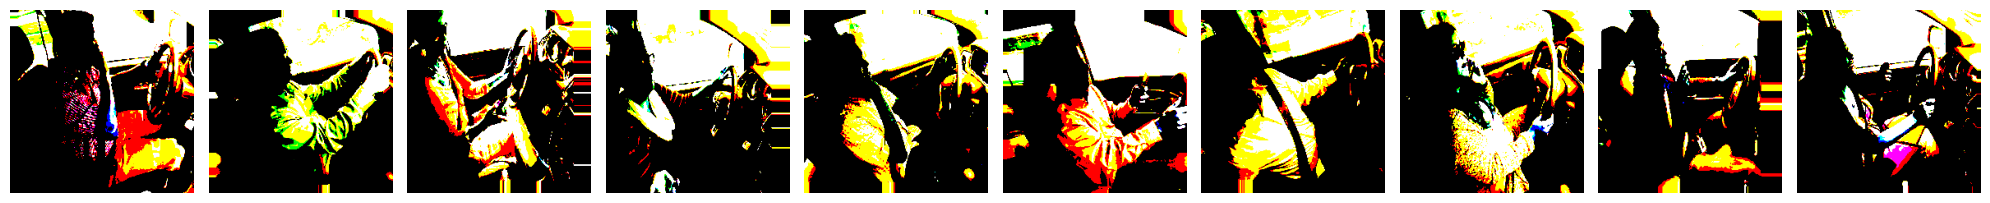

In [57]:
data_preprocessing()

# Building Models

**Default parameters of MobileNet(**
 *   input_shape=None, alpha=1.0, depth_multiplier=1,
 *   dropout=0.001, include_top=True, weights="imagenet",
 *   input_tensor=None, pooling=None, classes=1000,
 *   classifier_activation="softmax", **kwargs)

**Mobilenet Architecture**

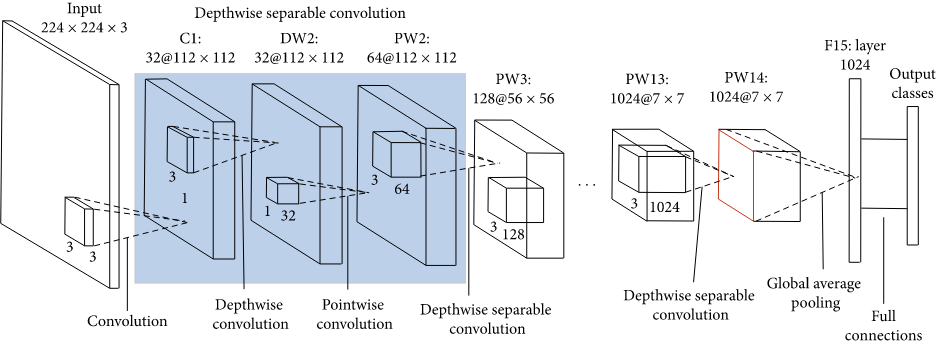

In [31]:
resnet = tf.keras.applications.resnet50.ResNet50()
resnet.summary()

102981632/102967424 [==============================] - 10s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                       

**Transfer Learning taking mobilenet architecture and pretrained weights from Imagenet**

In [33]:
x = resnet.layers[-6].output     # taking all mobilenet layers except last 5 layers
x = GlobalAveragePooling2D()(x)
output = Dense(units=n_classes, activation='softmax')(x)     # adding extra Dense layer with 10 classes, softmax activation 
model = Model(inputs=resnet.input, outputs=output)   # combining mobile.input and mobilenet & Dense layers as output

In [34]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

**Fine-Tuning**

**When a trainable weight becomes non-trainable, its value is no longer updated during training.**

In [35]:
# freezing from 0 layer till last 23 rd layer on model
for layer in model.layers[:-23]:    
    layer.trainable = False
# after model.compile you can see 
# Trainable params: 1,873,930 
# because of freezing nearly half layers

**Model Compile**

In [23]:
model.compile(optimizer=Adam(learning_rate=learning_rate),    # using Adam optimizer with learning rate 0.001
              loss='categorical_crossentropy',     # using categorical_crossentropy loss as our data 10 classes
              metrics=['accuracy'])

**Model summary**

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

**Training model**

In [25]:
history = model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),  # here is train images divided to batch size 7840/20=392
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=epochs,    # 5 epochs
            verbose=1         # to verbose 1 to show animated epochs
)

Epoch 1/5
392/392 [==============================] - 174s 440ms/step - loss: 0.3156 - accuracy: 0.8972 - val_loss: 0.8204 - val_accuracy: 0.7898
Epoch 2/5
392/392 [==============================] - 146s 373ms/step - loss: 0.1129 - accuracy: 0.9662 - val_loss: 0.9266 - val_accuracy: 0.7464
Epoch 3/5
392/392 [==============================] - 150s 383ms/step - loss: 0.0711 - accuracy: 0.9773 - val_loss: 2.0714 - val_accuracy: 0.5985
Epoch 4/5
392/392 [==============================] - 148s 378ms/step - loss: 0.0600 - accuracy: 0.9821 - val_loss: 0.2512 - val_accuracy: 0.9296
Epoch 5/5
392/392 [==============================] - 147s 375ms/step - loss: 0.0453 - accuracy: 0.9865 - val_loss: 0.1807 - val_accuracy: 0.9500


In [36]:
0.05895785242319107

0.05895785242319107

In [37]:
history.history['loss']

[0.3155917227268219,
 0.11287075281143188,
 0.07113293558359146,
 0.06003317981958389,
 0.045300524681806564]

# Building Second Model with all freezing layers

**Importing Mobilenet**

In [38]:
mobile_1 = tf.keras.applications.mobilenet.MobileNet()
mobile_1.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

**Fine-tuning**

**In this second model we first import mobilnet architecture then freeze only mobilenet layers, but what we add Dense layer we do not freeze it**

In [39]:
for layer in mobile_1.layers:        # all mobilenet layers freezing
    layer.trainable = False
# after model.compile you can see 
# Trainable params: 10,250
# because of freezing nearly mobilenet layers except last Dense layer

**Transfer Learning**

In [40]:
y = mobile_1.layers[-6].output
y = GlobalAveragePooling2D()(y)
output = Dense(units=n_classes, activation='softmax')(y)
model_1 = tf.keras.Model(inputs=mobile_1.input, outputs=output)

**Model compile**

In [41]:
model_1.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

**Model summary**

In [42]:
model_1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

**Training model**

In [43]:
history_1 = model_1.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=epochs,
            verbose=1
)

Epoch 1/5
392/392 [==============================] - 128s 325ms/step - loss: 1.6405 - accuracy: 0.4603 - val_loss: 3.9565 - val_accuracy: 0.1551
Epoch 2/5
392/392 [==============================] - 126s 321ms/step - loss: 1.0129 - accuracy: 0.7013 - val_loss: 4.7649 - val_accuracy: 0.1638
Epoch 3/5
392/392 [==============================] - 132s 336ms/step - loss: 0.7981 - accuracy: 0.7712 - val_loss: 5.4805 - val_accuracy: 0.1638
Epoch 4/5
392/392 [==============================] - 135s 345ms/step - loss: 0.6725 - accuracy: 0.8093 - val_loss: 5.3368 - val_accuracy: 0.1735
Epoch 5/5
392/392 [==============================] - 134s 342ms/step - loss: 0.5931 - accuracy: 0.8306 - val_loss: 6.4614 - val_accuracy: 0.1393


**Saving the models**

In [44]:
model.save('my_model.h5')
model_1.save('my_model_1.h5')

**Making graph for acc, val_acc, loss and val_loss**

In [45]:
def model_graph(model_history, title):
    acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']

    loss=model_history.history['loss']
    val_loss=model_history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig((title +'.png'), format='png', dpi=600) # saving img as png

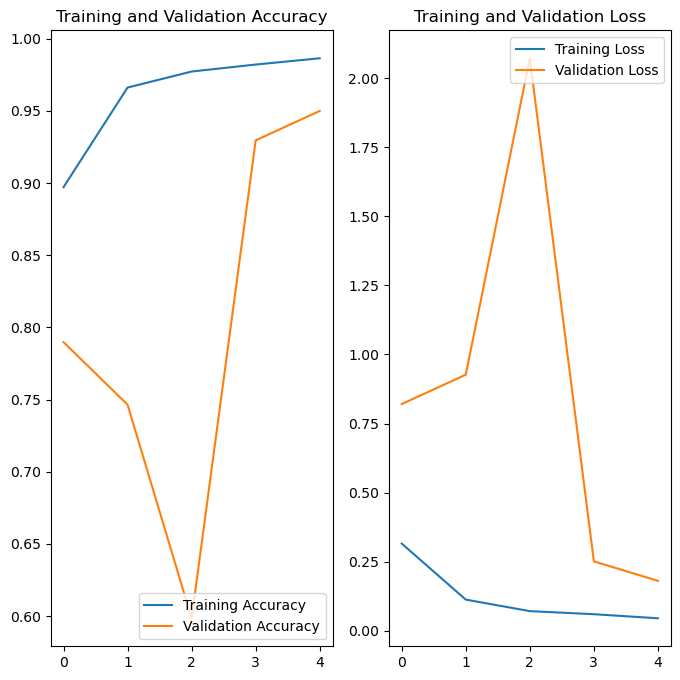

<Figure size 640x480 with 0 Axes>

In [46]:
model_graph(history, 'graph of half_freezed_model')

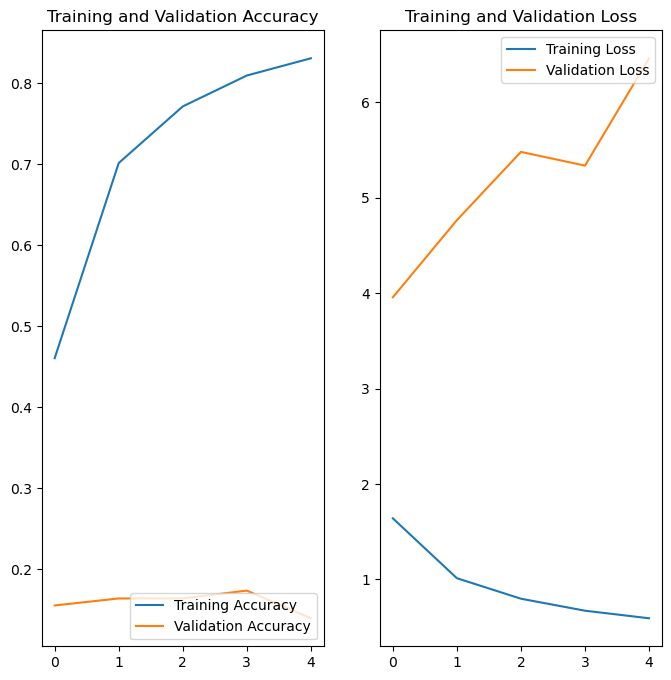

<Figure size 640x480 with 0 Axes>

In [47]:
model_graph(history_1, 'graph of all_freezed_model')

**Load the model**

In [48]:
#new_model = tf.keras.models.load_model('my_model.h5')

**Predictions of 200 images on test folder**

In [49]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=1)

10/10 [==============================] - 9s 819ms/step


In [50]:
predictions_1 = model_1.predict(x=test_batches, steps=len(test_batches), verbose=1)

10/10 [==============================] - 3s 232ms/step


**Making Confusion Matrix to see 200 images result**

In [51]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig((title +'.png'), format='png', dpi=600) # saving img as png

In [52]:
def make_confusion_matrix(test_label, predictions, model_name):
    cm = confusion_matrix(y_true=test_label, y_pred=predictions.argmax(axis=1))
    plot_confusion_matrix(cm=cm, classes=org_labels, title= ('Confusion Matrix of ' + model_name))

Confusion matrix, without normalization
[[ 0  0 20  0  0  0  0  0  0  0]
 [ 0  0 15  0  0  0  0  0  5  0]
 [ 0  0 20  0  0  0  0  0  0  0]
 [ 0  0 19  0  0  0  0  0  1  0]
 [ 0  0 20  0  0  0  0  0  0  0]
 [ 0  0 20  0  0  0  0  0  0  0]
 [ 0  0 20  0  0  0  0  0  0  0]
 [ 0  0 18  0  0  0  0  0  2  0]
 [ 0  0 20  0  0  0  0  0  0  0]
 [ 0  0 17  0  0  0  0  0  3  0]]


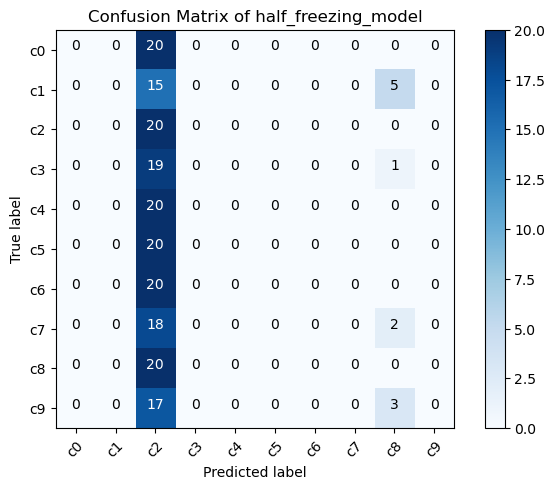

In [53]:
make_confusion_matrix(test_label, predictions, 'half_freezing_model')

Confusion matrix, without normalization
[[ 0  0  0  0 15  0  0  3  0  2]
 [ 0  0  0  0 13  0  0  5  0  2]
 [ 0  0  1  0 12  0  0  6  0  1]
 [ 0  0  0  0 16  0  0  1  0  3]
 [ 0  0  0  0 19  0  0  0  0  1]
 [ 0  0  0  0 16  0  0  2  0  2]
 [ 0  0  0  0 17  0  0  3  0  0]
 [ 0  0  0  0 10  0  0  9  0  1]
 [ 0  0  0  0  7  0  0  7  0  6]
 [ 0  0  0  0 17  0  0  1  0  2]]


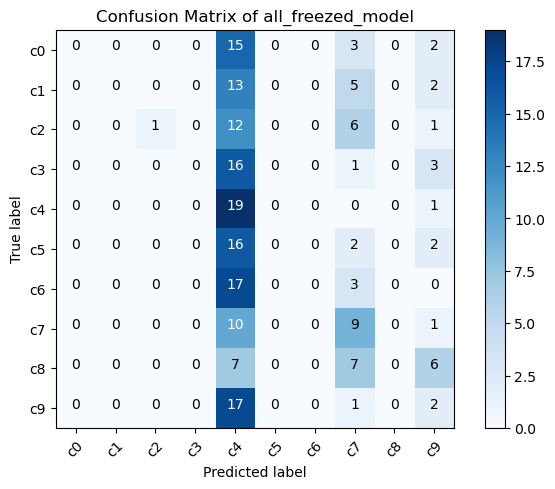

In [54]:
make_confusion_matrix(test_label, predictions_1, 'all_freezed_model')

# Summary of the two models
**As we use mobilnet architecture and add only one Dense layer for transfer learning, we compared 2 kind of fine-tuning model:**

1.   Half freezed layers (in my case)
*   Freezed from 0 till last 23 rd layers
*   Trainable params: 1,873,930
*   10000 images 5 epochs
*   loss: 0.0451 - accuracy: 0.9848 - val_loss: 0.1444 - val_accuracy: 0.9577 
*   Prediction result: 7 mistakes out of 200 unseen test images  96.5% correct
2.   all freezed layers
*   Freezed from 0 till last Dense layers
*   Trainable params: 10,250
*   10000 images 5 epochs
*   loss: 0.3117 - accuracy: 0.9224 - val_loss: 0.3290 - val_accuracy: 0.9077 
*   Prediction result: 16 mistakes out of 200 unseen test images  92% correct

**Finally, after compering 2 models, we can assume that fine-tuning gives some advantages for our model**


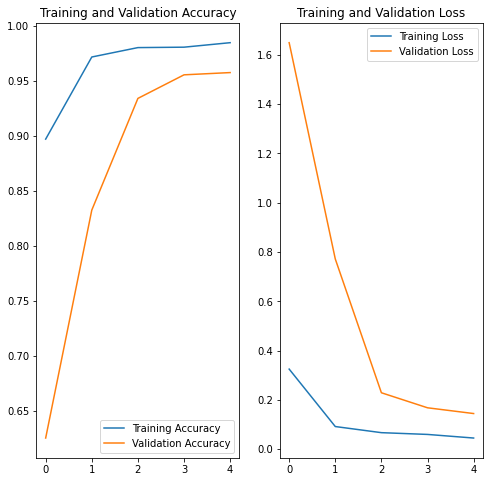
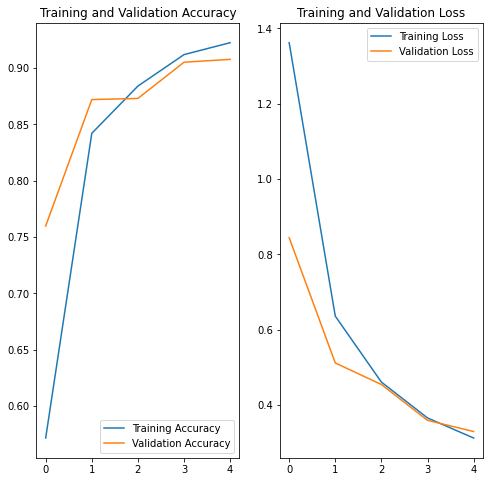

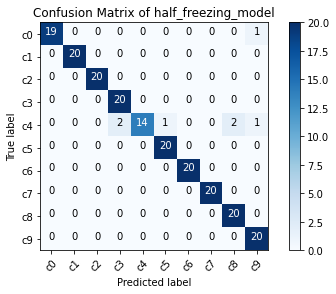
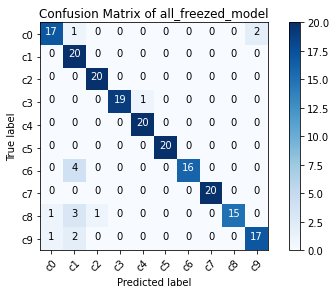

# Testing manually

In [39]:
test_data_folder = '/content/Distracted_driver_data/Distracted_driver/test/'  #path your test_data_folder

In [41]:
def test_manually(file):
    img = image.load_img(test_data_folder + file, target_size=(img_size, img_size)) #path your test_data_folder 
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    preprocessed_image = tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)
    prediction = model.predict(preprocessed_image)
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(final_labels[np.argmax(prediction)], 100 * np.max(prediction))
    )

In [51]:
img_name = 'img_57.jpg'

In [52]:
test_manually(img_name)

1/1 [==============================] - 0s 17ms/step
This image most likely belongs to Talking to passenger with a 90.75 percent confidence.


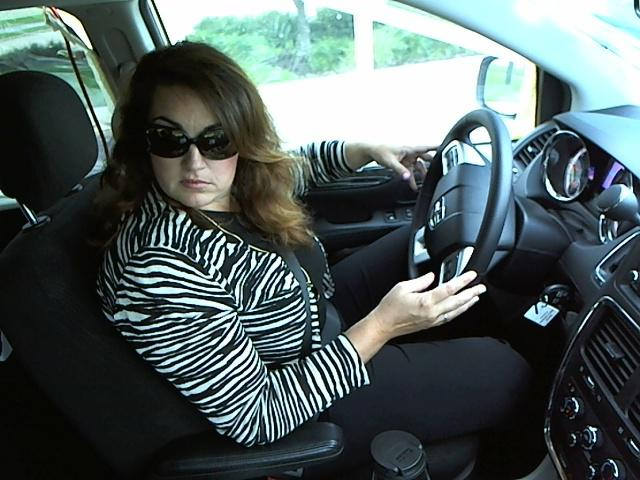

In [53]:
Image(filename=(test_data_folder + img_name), width=300,height=200)

**Example of tested img**

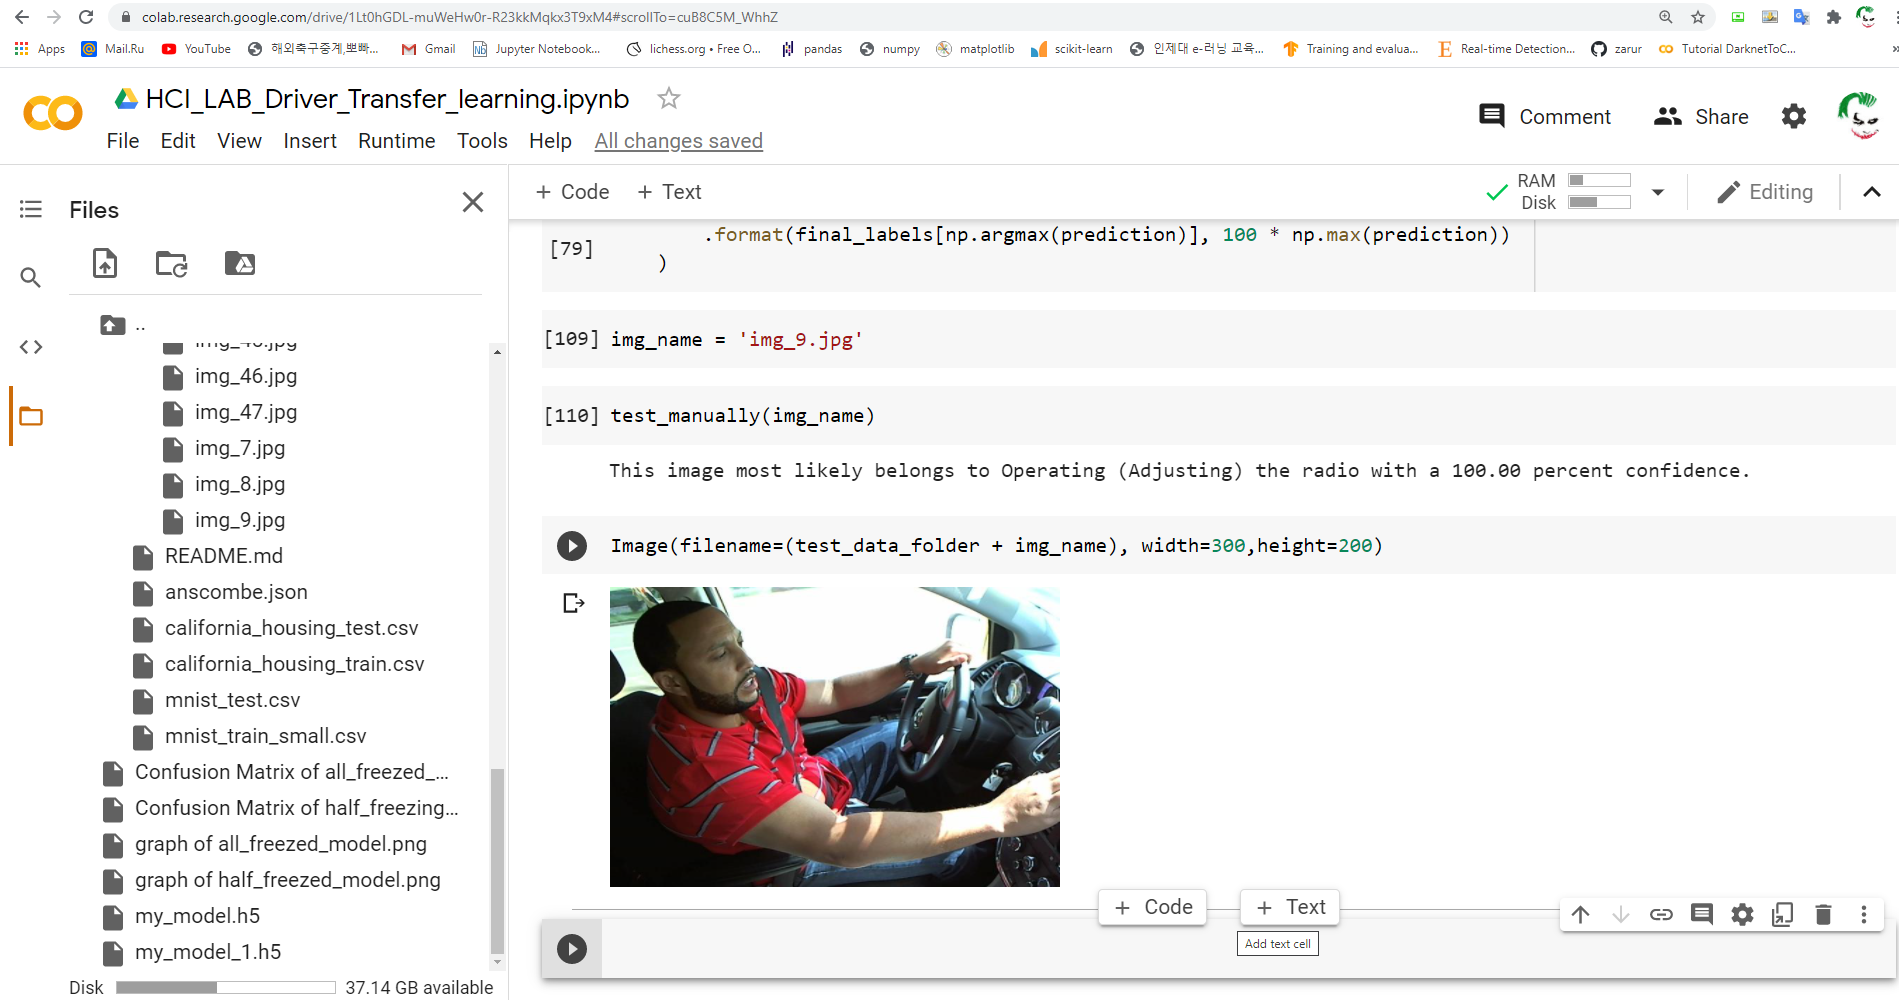

# Assignment

**Try to use different models: https://keras.io/api/applications/**

*   VGG16
*   ResNet50
*   Xception

**Use all freezing as well as half freezing select till which layer you want**

**Then compare it**